## How to use Transformer Networks to build a Forecasting model
- https://towardsdatascience.com/how-to-use-transformer-networks-to-build-a-forecasting-model-297f9270e630

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div>
<div style="text-align: right"> Initial upload: 2023.11.06</div>
<div style="text-align: right"> Last update: 2023.11.06</div>

In [1]:
import datetime
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline
# print(plt.stype.available)

# Options for pandas
pd.options.display.max_columns = 30

In [6]:
from tqdm import tqdm

### The Model

우리가 사용할 모델은 인코더-디코더 트랜스포머로,  
인코더 부분은 시계열의 히스토리를 입력으로 받아들이고 디코더 부분은 auto-regressive 방식으로 미래 값을 예측합니다.

디코더는 어텐션 메커니즘을 사용하여 인코더와 연결됩니다.  
이렇게 하면 디코더는 예측을 하기 전에 시계열의 과거 값 중 가장 유용한 부분에 '집중'하는 방법을 학습할 수 있습니다.

디코더는 마스킹된 셀프어텐션을 사용하여 네트워크가 훈련 중에 과거 값을 예측하기 위해 미래 값을 사용함으로써 속임수를 쓰지 못하도록 합니다.


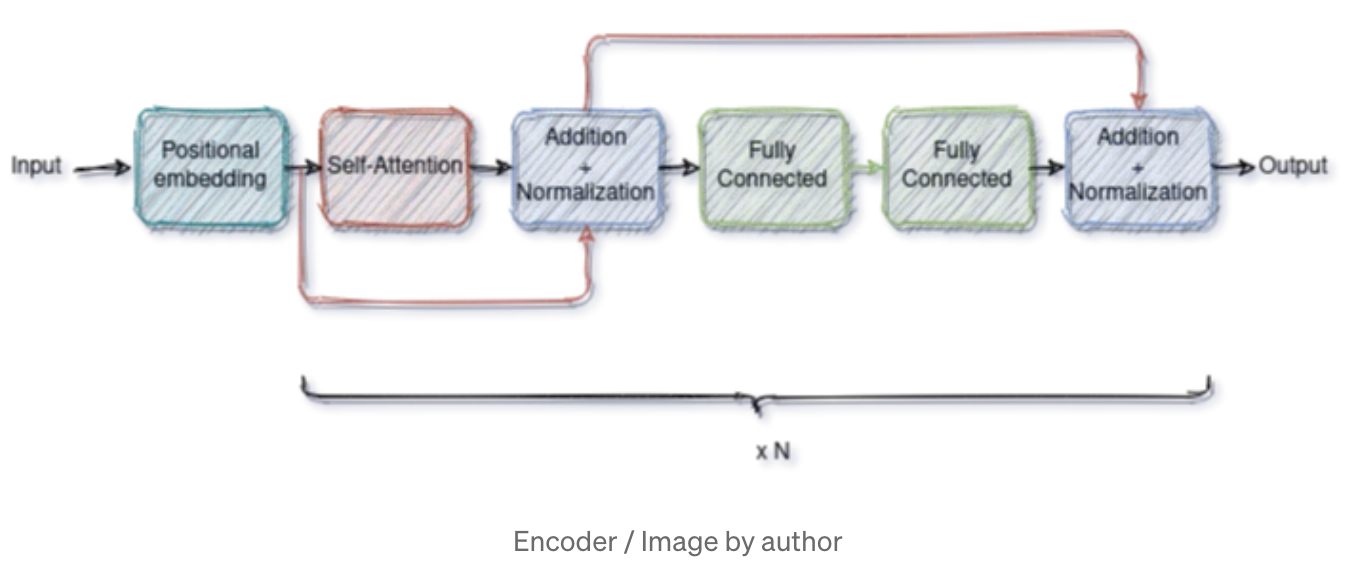

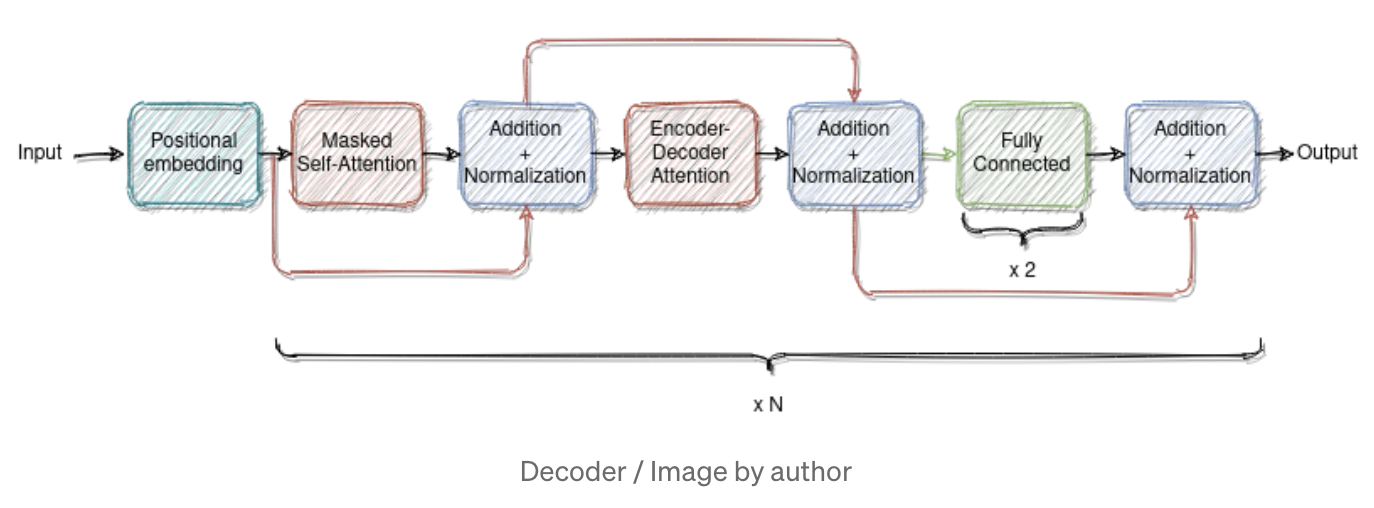

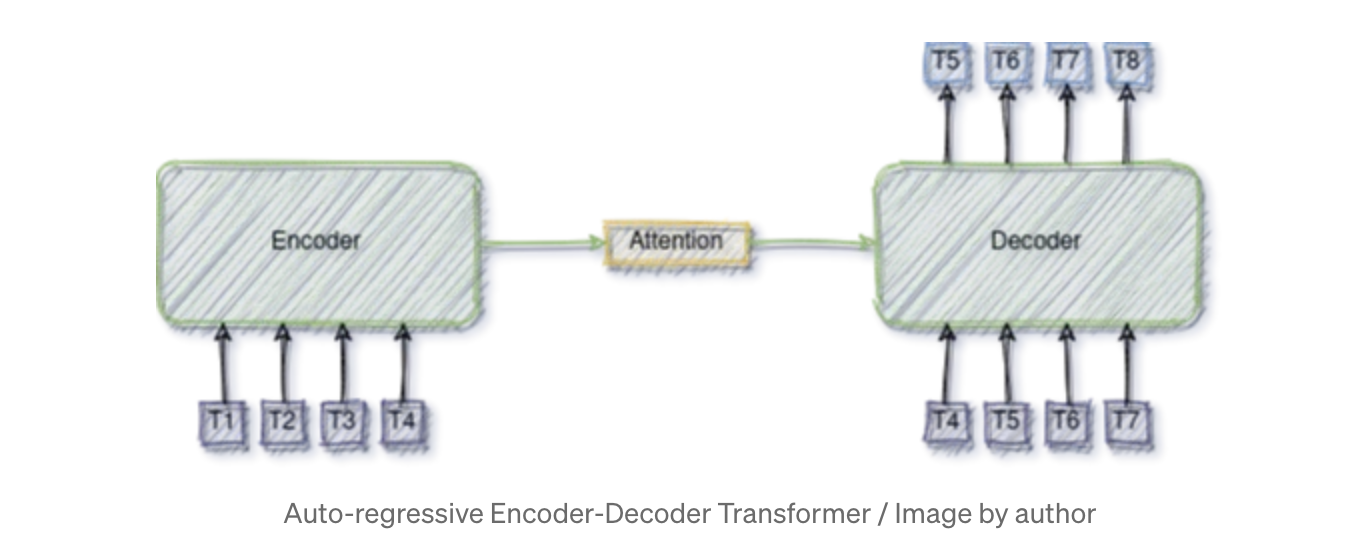

대략적인 코드는 다음과 같아진다.   


```python
encoder_layer = nn.TransformerEncoderLayer(
    d_model=channels,
    nhead=8,
    dropout=self.dropout,
    dim_feedforward=4 * channels,
)
decoder_layer = nn.TransformerDecoderLayer(
    d_model=channels,
    nhead=8,
    dropout=self.dropout,
    dim_feedforward=4 * channels,
)

self.encoder = torch.nn.TransformerEncoder(encoder_layer, num_layers=8)
self.decoder = torch.nn.TransformerDecoder(decoder_layer, num_layers=8)
```

### The data:

저는 새로운 접근 방식을 구현할 때마다 이해하기 쉽고 디버깅하기 쉽도록 합성 데이터에 먼저 시도하는 것을 좋아합니다.   
이렇게 하면 데이터의 복잡성이 줄어들고 구현/알고리즘에 더 집중할 수 있습니다.

저는 주기, 오프셋, 패턴이 다른, 단순하지 않은 않은 시계열을 생성할 수 있는 작은 스크립트를 작성했습니다.

In [2]:
from generate_time_series import generate_df

In [3]:
test_df = generate_df()

In [4]:
test_df

,timestamp,index,article,amplitude,offset,views
0,2015-01-01,0,f15c2861692e44de8e0f039cb3542f1a,-0.461966,-0.575768,-0.672876
1,2015-01-02,1,f15c2861692e44de8e0f039cb3542f1a,-0.457766,-0.564488,-0.704825
2,2015-01-03,2,f15c2861692e44de8e0f039cb3542f1a,-0.453565,-0.582205,-0.875752
3,2015-01-04,3,f15c2861692e44de8e0f039cb3542f1a,-0.449364,-0.625854,-0.928201
4,2015-01-05,4,f15c2861692e44de8e0f039cb3542f1a,-0.445163,-0.687888,-1.067773
...,...,...,...,...,...,...
1822,2019-12-28,1822,f15c2861692e44de8e0f039cb3542f1a,0.487399,-0.872502,-1.268166
1823,2019-12-29,1823,f15c2861692e44de8e0f039cb3542f1a,0.491600,-0.897859,-1.339367
1824,2019-12-30,1824,f15c2861692e44de8e0f039cb3542f1a,-0.461966,-0.894569,-0.606554
1825,2019-12-31,1825,f15c2861692e44de8e0f039cb3542f1a,-0.457766,-0.863201,-0.521897


<Axes: xlabel='timestamp'>

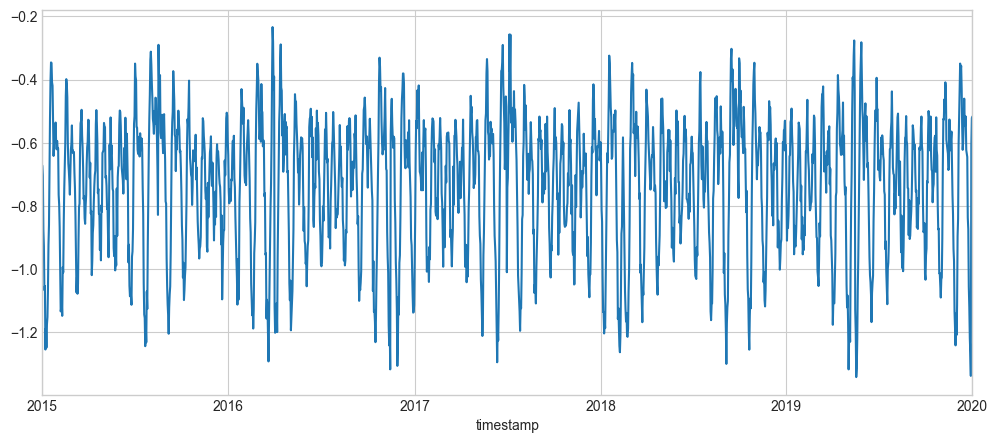

In [5]:
test_df.set_index("timestamp")['views'].plot(figsize = (12, 5))

여러개 데이터셋 만들어저 저장하기

In [7]:
dataframes = []

for _ in tqdm(range(20000)):
    df = generate_df()
    
    dataframes.append(df)

100%|██████████| 20000/20000 [04:43<00:00, 70.59it/s]


In [12]:
display(dataframes[0].head())
print(dataframes[0].shape)

,timestamp,index,article,amplitude,offset,views
0,2015-01-01,0,e288d86c0c8641a7b25ba1cc435e28d7,3.203435,0.774873,2.014996
1,2015-01-02,1,e288d86c0c8641a7b25ba1cc435e28d7,3.197775,0.743587,3.224294
2,2015-01-03,2,e288d86c0c8641a7b25ba1cc435e28d7,3.192114,0.716603,2.987859
3,2015-01-04,3,e288d86c0c8641a7b25ba1cc435e28d7,3.186454,0.694619,3.996244
4,2015-01-05,4,e288d86c0c8641a7b25ba1cc435e28d7,3.180794,0.678206,3.763220


(1827, 6)


In [13]:
display(dataframes[1].head())
print(dataframes[1].shape)

,timestamp,index,article,amplitude,offset,views
0,2015-01-01,0,b938ef7e739547ce92af0a33bf2c14d3,1.640358,-0.990349,-2.079578
1,2015-01-02,1,b938ef7e739547ce92af0a33bf2c14d3,1.637785,-0.981947,-1.854744
2,2015-01-03,2,b938ef7e739547ce92af0a33bf2c14d3,1.635212,-0.973160,-2.136563
3,2015-01-04,3,b938ef7e739547ce92af0a33bf2c14d3,1.632639,-0.964228,-2.219033
4,2015-01-05,4,b938ef7e739547ce92af0a33bf2c14d3,1.630066,-0.955395,-2.088749


(1827, 6)


In [14]:
all_data = pd.concat(dataframes, ignore_index=True)
all_data.to_csv("data/data.csv", index=False)